## Aditya Jindal
## Batch T6
## EIP3P2 Assignment5
## GradCAM on ResNet18 Cifar10 

In [1]:
pip install image-classifiers

     |████████████████████████████████| 81kB 3.1MB/s 


In [2]:
pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-7ftv63s7
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-7ftv63s7
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-gl5vt8m8/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [3]:
import keras
from keras import backend as K
import time
import cv2
from classification_models.resnet import ResNet18, preprocess_input
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from keras.utils import np_utils
from keras.layers import GlobalAveragePooling2D, Conv2D, Activation
from keras.models import Model
from keras.layers import Input
from keras.optimizers import SGD
from keras.callbacks import *



Using TensorFlow backend.


In [4]:
# Loading a database and getting unique number of classes
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

print(num_classes)
print(train_features.shape)
print(test_features.shape)

170500096/170498071 [==============================] - 2s 0us/step
10
(50000, 32, 32, 3)
(10000, 32, 32, 3)


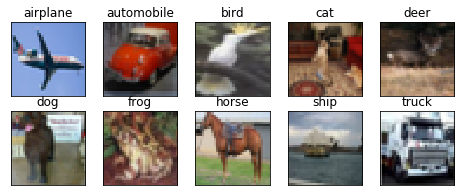

In [5]:
# Printing mentioned classes samples

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()



In [0]:
# Defining function to plot loss and accuracy for model
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function to get accuracy on our test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Set/Convert all the pixel values to float data type 
# Normalizing all pixel values by dividing with 255 so that every value lies btw 0-1

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Converted the above 1-dimensional class label arrays to num_classes-dimensional class matrices
# As the test and train labels are not splitted into num_classes distinct labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels_category = np_utils.to_categorical(test_labels, num_classes)

In [9]:
#Mounting drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
# Using a pretrained model of Resnet18 on Imagenet Dataset
# Retraining the same on Cifar10 Dataset

n_classes = 10

base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)

## Note: As internally the base_model have used Dense, Strides > 1, Kernel size > 3, and Pool size > 2
##       Cant changes those until we rewrite the network and retrain

# Reducing 1000 to 10 classes
Conv1 = Conv2D(10, (1,1))(base_model.output)

GAP = GlobalAveragePooling2D()(Conv1)

output = Activation('softmax')(GAP)

model = Model(inputs=[base_model.input], outputs=[output])

model.summary()


W0701 18:07:51.192287 140616962865024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 18:07:51.244413 140616962865024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 18:07:51.245318 140616962865024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 18:07:51.249226 140616962865024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0701 18:07:51.250230 140616

44924928/44920640 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
____________________________________________

In [11]:
# Compile the model

model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

weights_path="/content/gdrive/My Drive/EIP3_Weights/gradCAM/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(weights_path, monitor='val_acc', verbose=1, save_best_only=False, mode='max', save_weights_only = False, period = 1)

W0701 18:07:58.238741 140616962865024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



W0630 12:51:29.118991 140505647814528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 22s 443us/step - loss: 0.8363 - acc: 0.7124 - val_loss: 0.7235 - val_acc: 0.7501

Epoch 00001: saving model to /content/gdrive/My Drive/EIP3_Weights/gradCAM/weights-improvement-01-0.75.hdf5
Epoch 2/15
50000/50000 [==============================] - 16s 327us/step - loss: 0.4793 - acc: 0.8321 - val_loss: 0.6350 - val_acc: 0.7897

Epoch 00002: saving model to /content/gdrive/My Drive/EIP3_Weights/gradCAM/weights-improvement-02-0.79.hdf5
Epoch 3/15
50000/50000 [==============================] - 16s 329us/step - loss: 0.3407 - acc: 0.8807 - val_loss: 0.6328 - val_acc: 0.8016

Epoch 00003: saving model to /content/gdrive/My Drive/EIP3_Weights/gradCAM/weights-improvement-03-0.80.hdf5
Epoch 4/15
50000/50000 [==============================] - 16s 329us/step - loss: 0.2388 - acc: 0.9145 - val_loss: 0.7730 - val_acc: 0.7820

Epoch 00004: saving model to /content/gdrive/My Drive/EIP3_Weights

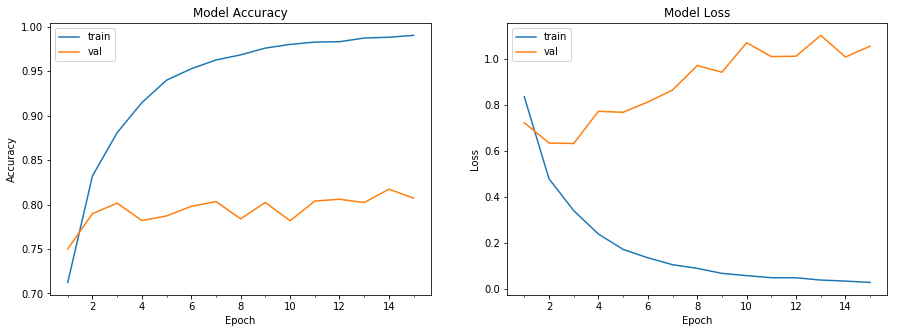

Accuracy on test data is: 80.72 


In [0]:
# Train the model
start = time.time()
model_tuned = model.fit(train_features, train_labels, batch_size = 128,
                                 epochs = 15,validation_data = (test_features, test_labels_category), verbose=1, callbacks = [checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_tuned)
# compute test accuracy
print ("Accuracy on test data is: %0.2f "%accuracy(test_features, test_labels_category, model))

In [0]:
# Loading Trained Model with Highest accuracy weights

model.load_weights("/content/gdrive/My Drive/EIP3_Weights/gradCAM/weights-improvement-14-0.82.hdf5")

model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# GradCam function to create heatmap superimposed images with original images

def gradCam(img, layerName, out_channels):
  img1 = np.expand_dims(img, axis=0)
  
  preds = model.predict(img1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layerName)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img1])
  for i in range(out_channels):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = np.uint8(255 * img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  cv2.waitKey(0)
  
  return superimposed_img

1828  incorrect classification


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


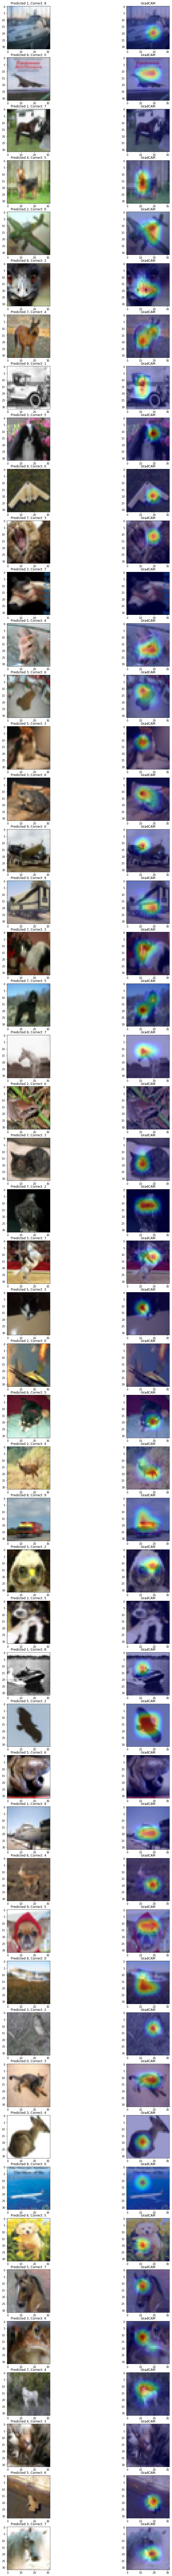

In [14]:
# Gallery for 50 misclassified class images and displaying their gradCAM results

model_pred = model.predict(test_features)
pred_classes = np.argmax(model_pred, axis = 1)

# getting incorrect indices
incorrect_indices = np.nonzero(pred_classes != np.nonzero(test_labels_category)[1])[0]

print(len(incorrect_indices)," incorrect classification")

fig, ax = plt.subplots(50, 2, figsize = (15, 180))

for num, incorrect in enumerate(incorrect_indices[:50]):
    grad_img = gradCam(test_features[incorrect], "zero_padding2d_15", 256)
    ax[num,0].set_title("Predicted {}, Correct: {}".format(pred_classes[incorrect], 
                                       test_labels[incorrect][0]))
    ax[num,0].imshow(test_features[incorrect])
    ax[num,1].set_title("GradCAM")
    ax[num,1].imshow(grad_img)
plt.show()